Epoch 1/10


/var/folders/9f/bmdlbz697f77v4pnzy4g6bwh0000gn/T/ipykernel_2130/2801799641.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['scaled_temp'] = scaler.fit_transform(train_df[['temperature']])
/var/folders/9f/bmdlbz697f77v4pnzy4g6bwh0000gn/T/ipykernel_2130/2801799641.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['scaled_temp']  = scaler.transform(test_df[['temperature']])
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_s

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2457  
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1866
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1389
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1106
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0681
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230
MAE:  5.788 °C
RMSE: 6.400 °C
R²:    -4.157


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


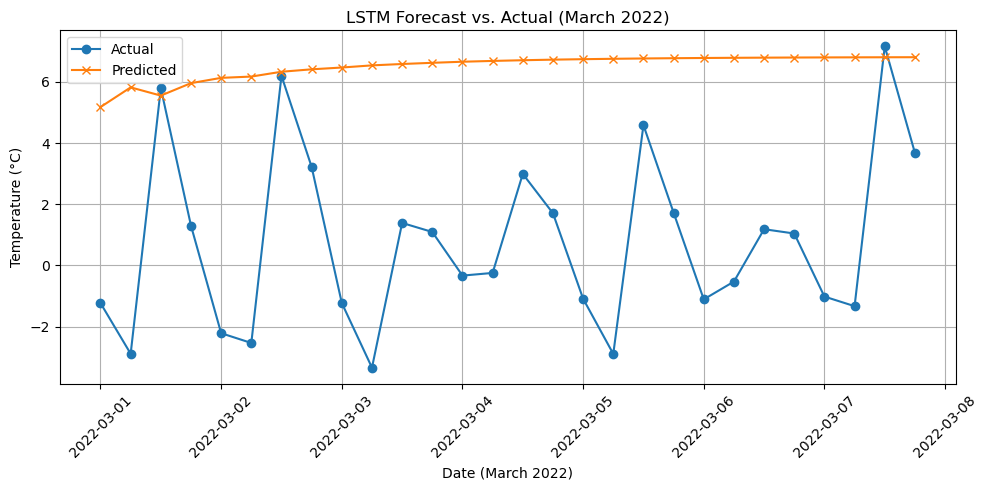

In [2]:
import cdsapi
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load dataset (already downloaded)
ds = xr.open_dataset("berlin_temp_2022.nc")

temperature = ds['t2m'] - 273.15  # Convert from Kelvin to Celsius
df = temperature.to_dataframe().reset_index()

# Rename columns
df = df[['valid_time', 't2m']].rename(columns={'time': 'valid_time', 't2m': 'temperature'})
df['temperature'] = df['temperature'].astype('float32')
df['valid_time'] = pd.to_datetime(df['valid_time'])

# Split into train/test
train_df = df[(df['valid_time'] >= '2022-01-01') & (df['valid_time'] < '2022-03-01')]
test_df  = df[(df['valid_time'] >= '2022-03-01') & (df['valid_time'] < '2022-04-01')]

# Scale temperatures
scaler = MinMaxScaler()
train_df['scaled_temp'] = scaler.fit_transform(train_df[['temperature']])
test_df['scaled_temp']  = scaler.transform(test_df[['temperature']])

# Create LSTM sequences
WINDOW_SIZE = 3

def create_sequences(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_df['scaled_temp'].values, window_size=WINDOW_SIZE)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define and train model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# Predict on test set (rolling forecast)
last_seq = train_df['scaled_temp'].values[-WINDOW_SIZE:].tolist()
preds_scaled = []
for _ in range(len(test_df)):
    input_seq = np.array(last_seq[-WINDOW_SIZE:]).reshape((1, WINDOW_SIZE, 1))
    next_pred = model.predict(input_seq, verbose=0)[0, 0]
    preds_scaled.append(next_pred)
    last_seq.append(next_pred)

# Inverse transform to Celsius
preds_actual = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
actuals = test_df['temperature'].values

# Evaluation
mae  = mean_absolute_error(actuals, preds_actual)
rmse = mean_squared_error(actuals, preds_actual, squared=False)
r2   = r2_score(actuals, preds_actual)

print(f"MAE:  {mae:.3f} °C")
print(f"RMSE: {rmse:.3f} °C")
print(f"R²:    {r2:.3f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(test_df['valid_time'].values, actuals, label='Actual', marker='o')
plt.plot(test_df['valid_time'].values, preds_actual, label='Predicted', marker='x')
plt.xlabel('Date (March 2022)')
plt.ylabel('Temperature (°C)')
plt.title('LSTM Forecast vs. Actual (March 2022)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
